In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import open_clip
from tqdm import tqdm
import torch.utils.data as torch_data

/home/user/anaconda3/envs/robosuite/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!pwd

/home/user/Documents/projects/robosuite-notebooks/datagen


In [42]:
dataset_folder = "/home/user/Documents/projects/robosuite-notebooks/datagen/clip_data_03_04"

In [43]:
info = json.load(open(os.path.join(dataset_folder, "info.json"), "r"))

tasks = list(info["tasks"].keys())

In [44]:
tasks[0]

'task_0'

In [45]:
info["tasks"][tasks[0]]["brick_shapes"]

{'1': [1, 1, 1],
 '2': [1, 1, 1],
 '3': [1, 3, 1],
 '4': [1, 2, 1],
 '5': [1, 2, 1],
 '6': [1, 1, 1],
 '0': [4, 4, 1]}

In [46]:
class BlocksDataset(torch_data.Dataset):

    def __init__(self, dataset_folder, img_preprocess_fun, text_tokenizer, preprocess=True) -> None:
        super().__init__()

        self.img_preprocess_fun = img_preprocess_fun
        self.text_tokenizer = text_tokenizer
        self.preprocess = preprocess

        self.info = json.load(open(os.path.join(dataset_folder, "info.json"), "r"))

        self.tasks_names = list(self.info["tasks"].keys())
        self.num_tasks = len(self.tasks_names)

        self.total_num_images = self.info["dataset"]["total_num_images"]
        img_res = self.info["dataset"]["img_res"]
        
        self.images = np.array(np.memmap(
            os.path.join(dataset_folder, "keyframe_images.data"),
            dtype=np.uint8,
            mode='r',
            shape=(self.total_num_images, 3, *img_res)
        )[:])

        self.idx_to_task = {}
        self.idx_to_sample = {}
        self.num_descriptions_per_index = 1


    def __len__(self):
        return self.num_tasks * self.num_descriptions_per_index
    
    def __getitem__(self, index):
        
        img_description_index = index % self.num_descriptions_per_index
        task_index = index % self.num_tasks

        # TODO sample from instruction
        task_name = self.tasks_names[task_index]
        keyframe_index = self.info["tasks"][task_name]["samples"][0]["keyframes_start_index"]

        img = self.images[keyframe_index]
        img = Image.fromarray(img.transpose(1, 2, 0))
        if self.preprocess:
            img = self.img_preprocess_fun(img)

        brick_shapes = self.info["tasks"][task_name]["brick_shapes"]
        brick_colors = self.info["tasks"][task_name]["samples"][0]["brick_colors"]
        brick_keys = brick_shapes.keys()
        img_description = "An image of a table with the following blocks on top of it:"
        # img_description_colors = "An image of a table with blocks on top of it that have the following colors:"
        # img_description_shapes = "An image of a table with blocks on top of it that have the following shape:"
        for brick_idx in range(len(brick_keys)):
            brick_color = " ".join(brick_colors[brick_idx].split("_"))
            brick_key = f"{brick_idx}"
            brick_shape = brick_shapes[brick_key]
            img_description += f" A block with shape {tuple(brick_shape)}."
            # img_description += f" A {brick_color} block with shape {tuple(brick_shape)}."
            # img_description_colors += f" {brick_color}" + ("," if brick_idx < len(brick_keys) - 1 else ".")
            # img_description_shapes += f" {tuple(brick_shape)}" + ("," if brick_idx < len(brick_keys) - 1 else ".")
        
        if self.preprocess:
            img_description = self.text_tokenizer(img_description)[0]
            # img_description_colors = self.text_tokenizer(img_description_colors)[0]
            # img_description_shapes = self.text_tokenizer(img_description_shapes)[0]

        img_descriptions = [
            img_description,
            # img_description_colors,
            # img_description_shapes
        ]
        img_description = img_descriptions[img_description_index]

        return img, img_description

In [47]:
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:laion/CLIP-ViT-B-16-laion2B-s34B-b88K')
tokenizer = open_clip.get_tokenizer('hf-hub:laion/CLIP-ViT-B-16-laion2B-s34B-b88K')

img_preprocess = preprocess_val

In [57]:
blocks_dataset = BlocksDataset(dataset_folder, img_preprocess, tokenizer, preprocess=True)
len(blocks_dataset)

2000

In [49]:
img, img_description = blocks_dataset[3]
# print(img.shape, img_description.shape)

In [50]:
img_description

'An image of a table with the following blocks on top of it: A block with shape (4, 4, 1). A block with shape (1, 3, 1). A block with shape (1, 2, 1). A block with shape (1, 2, 1). A block with shape (1, 2, 1). A block with shape (1, 10, 1). A block with shape (1, 6, 1).'

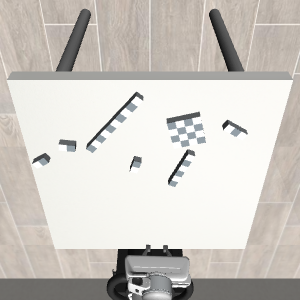

In [51]:
img

In [58]:
blocks_dataloader = torch_data.DataLoader(blocks_dataset, batch_size=10, shuffle=False)

In [30]:
img_batch, img_description_batch = next(iter(blocks_dataloader))
print(img_batch.shape, img_description_batch.shape)

torch.Size([10, 3, 224, 224]) torch.Size([10, 77])


# Encode Images & Sentences

In [53]:
device = "cuda"
model = model.to(device)

In [24]:
image_features = model.encode_image(img_batch.to(device))
print(image_features.shape)

NameError: name 'img_batch' is not defined

In [33]:
text_features = model.encode_text(img_description_batch.to(device))
print(text_features.shape)

torch.Size([10, 512])


In [54]:
FEATURE_DIM = 512
image_features = torch.empty((len(blocks_dataset), FEATURE_DIM))
text_features = torch.empty((len(blocks_dataset), FEATURE_DIM))
print(image_features.shape, text_features.shape)

torch.Size([2000, 512]) torch.Size([2000, 512])


In [55]:
model = model.to(device)

In [59]:
i = 0
model.eval()

for batch in tqdm(blocks_dataloader):
    img_batch, img_description_batch = batch
    b = img_batch.shape[0]
    img_batch = img_batch.to(device)
    img_description_batch = img_description_batch.to(device)

    image_features_batch = model.encode_image(img_batch)
    text_features_batch = model.encode_text(img_description_batch)

    image_features[i:i+b] = image_features_batch.detach().cpu()
    text_features[i:i+b] = text_features_batch.detach().cpu()

    i += b

100%|██████████| 200/200 [00:11<00:00, 17.95it/s]


In [60]:
torch.save(image_features, os.path.join(dataset_folder, "image_features.tar"))

In [61]:
torch.save(text_features, os.path.join(dataset_folder, "text_features.tar"))